In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/denoising-dirty-documents/train.zip
/kaggle/input/denoising-dirty-documents/sampleSubmission.csv.zip
/kaggle/input/denoising-dirty-documents/train_cleaned.zip
/kaggle/input/denoising-dirty-documents/test.zip


In [4]:
# path to zipped & working directories
path_zip = '/kaggle/input/denoising-dirty-documents/'
path = '/kaggle/working/'

In [5]:
# unzip files first to working directory
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [9]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

In [10]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [11]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

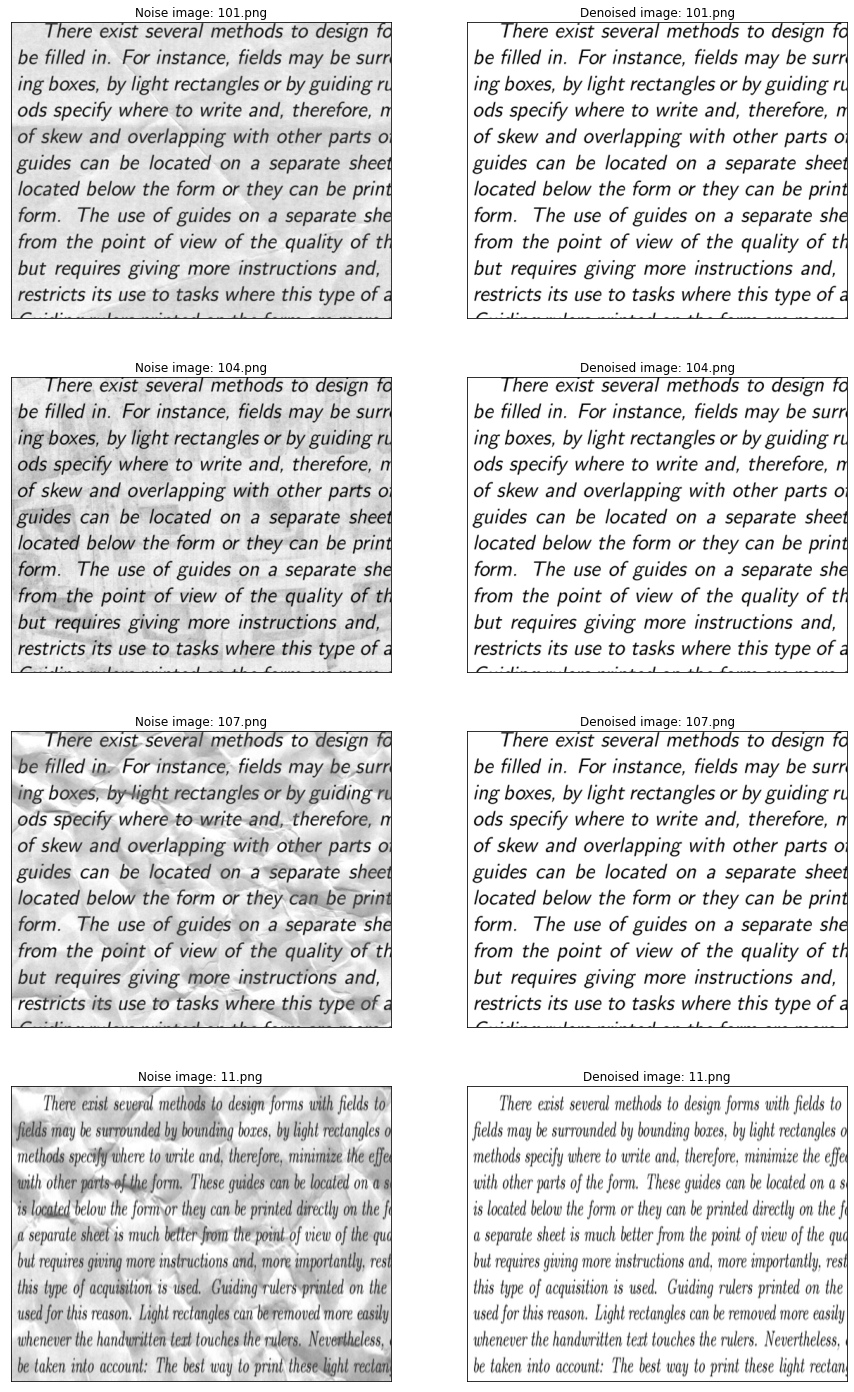

In [12]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

In [13]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

In [17]:
    print("X_train shape: " + str(X_train.shape))
    print("Y_train shape: " + str(Y_train.shape))
    print("X_test shape: " + str(X_test.shape))
    print("X_val shape: " + str(X_val.shape))
    print("Y_val shape: " + str(Y_val.shape))


X_train shape: (122, 420, 540, 1)
Y_train shape: (122, 420, 540, 1)
X_test shape: (72, 420, 540, 1)
X_val shape: (22, 420, 540, 1)
Y_val shape: (22, 420, 540, 1)


In [19]:
def model():
    input_layer = Input(shape=(420, 540, 1))  
    
    # encoding
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((2, 2), padding='same')(x)
    
    x = Dropout(0.5)(x)

    # decoding
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)

    x = UpSampling2D((2, 2))(x)

    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    model = Model(inputs=[input_layer], outputs=[output_layer])
    model.compile(optimizer='adam' , loss='mean_squared_error', metrics=['mae'])

    return model


model = model()
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 420, 540, 1)]     0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 420, 540, 64)      640       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 420, 540, 128)     73856     
_________________________________________________________________
batch_normalization_2 (Batch (None, 420, 540, 128)     512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 210, 270, 128)     0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 210, 270, 128)     0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 210, 270, 128)    

In [20]:
callback = EarlyStopping(monitor='loss', patience=30)
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=600, batch_size=24, verbose=2, callbacks=[callback])

Epoch 1/600
6/6 - 5s - loss: 0.1881 - mae: 0.3247 - val_loss: 0.2192 - val_mae: 0.4536
Epoch 2/600
6/6 - 3s - loss: 0.0922 - mae: 0.2084 - val_loss: 0.1798 - val_mae: 0.4116
Epoch 3/600
6/6 - 3s - loss: 0.0600 - mae: 0.1740 - val_loss: 0.1310 - val_mae: 0.3494
Epoch 4/600
6/6 - 3s - loss: 0.0463 - mae: 0.1504 - val_loss: 0.1194 - val_mae: 0.3316
Epoch 5/600
6/6 - 3s - loss: 0.0382 - mae: 0.1370 - val_loss: 0.0995 - val_mae: 0.2958
Epoch 6/600
6/6 - 3s - loss: 0.0328 - mae: 0.1220 - val_loss: 0.0860 - val_mae: 0.2648
Epoch 7/600
6/6 - 3s - loss: 0.0291 - mae: 0.1137 - val_loss: 0.0759 - val_mae: 0.2308
Epoch 8/600
6/6 - 3s - loss: 0.0261 - mae: 0.1067 - val_loss: 0.0726 - val_mae: 0.2093
Epoch 9/600
6/6 - 3s - loss: 0.0236 - mae: 0.1005 - val_loss: 0.0720 - val_mae: 0.2029
Epoch 10/600
6/6 - 3s - loss: 0.0214 - mae: 0.0983 - val_loss: 0.0712 - val_mae: 0.1809
Epoch 11/600
6/6 - 3s - loss: 0.0190 - mae: 0.0917 - val_loss: 0.0717 - val_mae: 0.1721
Epoch 12/600
6/6 - 3s - loss: 0.0172 - ma

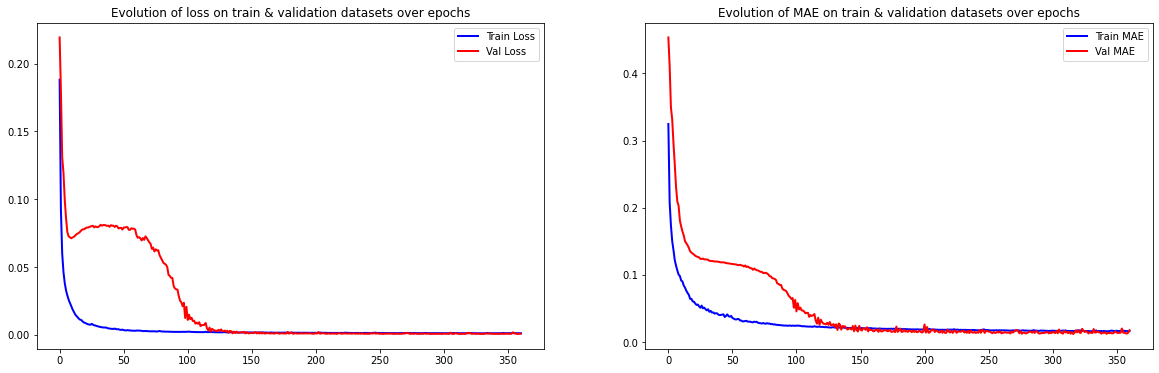

In [21]:

epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()


In [22]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=16)

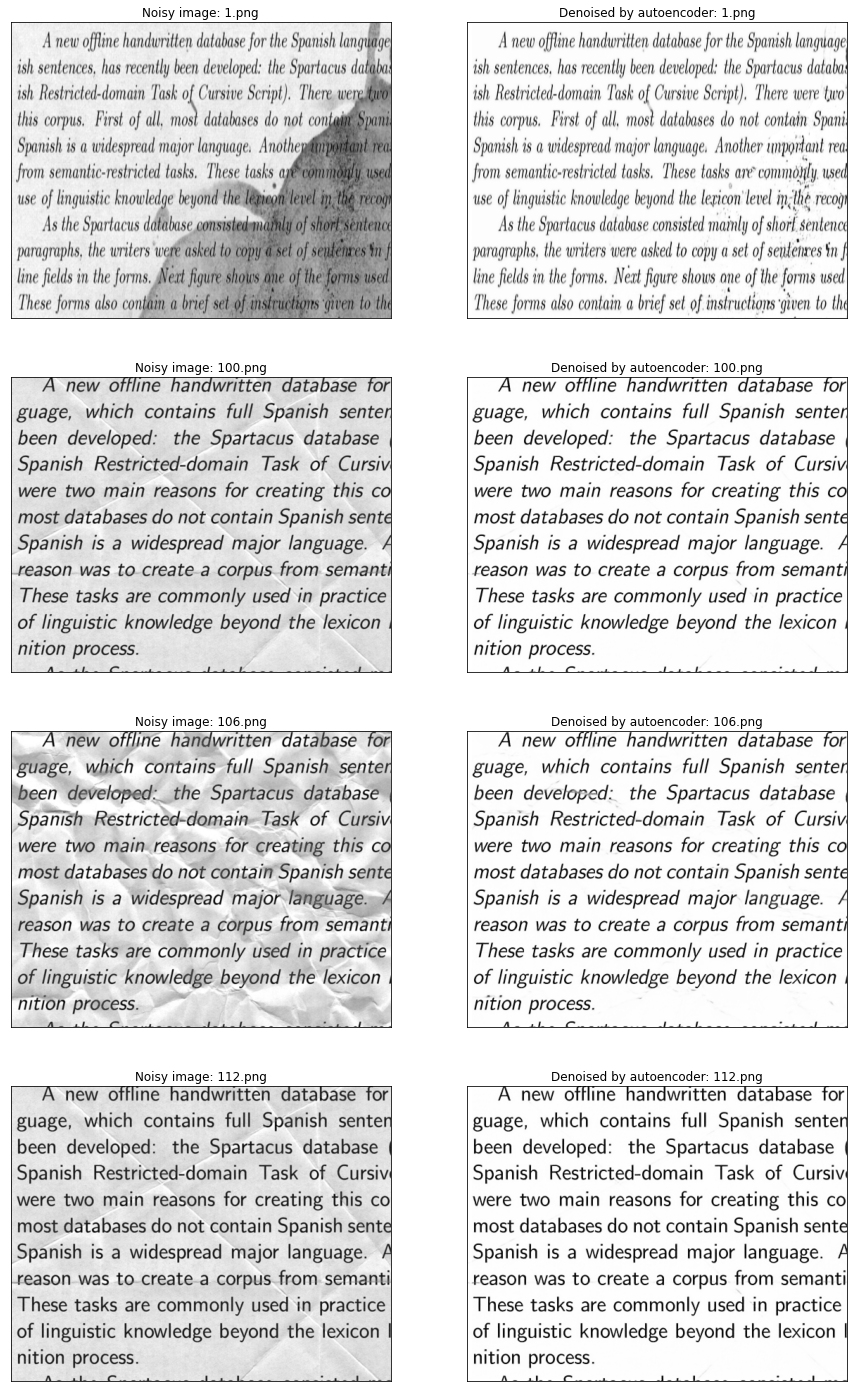

In [23]:
plt.figure(figsize=(15,25))
for i in range(0,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()